In [28]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
import pickle as pk
import yaml
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy import wcs
import os.path
from os import path

%matplotlib inline

In [29]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None


In [30]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec
    path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    #print(stamp)
    if write:
        temp = np.ndarray((2,), buffer=np.array([ra, dec]))    
        stamp.wcs.wcs.crval = temp
        enmap.write_map('./for_tony/mustang2/for_charles/y0_{}.fits'.format(name), stamp)
    return stamp


In [31]:
def getFlags(ra, dec, data):
    #Returns indeces of ra, dec that are inside a certain data 
    flags = []
    for i in range(len(ra)):
        if tileFinder(ra[i], dec[i], data) != None:
            flags.append(i)
    return flags

In [32]:
def freqStamp(ra, dec, fmap, name, width = 0.5, write = True, freq = ''):

    stamp = reproject.postage_stamp(fmap, ra, dec, width*60, 0.5)
    if write:
        temp = np.ndarray((2,), buffer=np.array([ra, dec]))    
        stamp.wcs.wcs.crval = temp
        enmap.write_map('./for_tony/mustang2/for_charles/{}_{}.fits'.format(freq, name), stamp)
    return stamp


In [33]:
def central_emission(hmap, map_w = 20., pixel_w = 0.5, max_sep = 1.2):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    
    emission = 0
    div = 0
    
    int_w = int(2*map_w)
    
    for i in range(int_w):
        for j in range(int_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                emission += hmap[i,j]
                div +=1
    return emission, div

In [34]:
def stamper(name, width = 0.5, write = True, plot = True):
    #Get ra/dec of cluster
    if name[:3] == 'ACT':
        ras, decs, snrs, zs, names = actRa, actDec, actSnr, actz, actNames

    flag = np.where((name == names))[0]

    ra, dec = ras[flag], decs[flag] 
    
    #y0 stamp and plot
    stamp = s18dStamp(ra, dec, s18d, name.replace(' ','_'), width = width, write = write)
    if plot:
        fig, axes = plt.subplots()
        bound = width*60/2
        plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])

        draw_circle = plt.Circle((0, 0), 2.4, color = 'r',fill=False, alpha = 0.5)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)
        cbar = plt.colorbar()
        cbar.set_label(r'$\widetilde{y}_0$ ($10^{-4}$)', rotation=270)

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')


        plt.title(r'$\widetilde{y}_0$ Map of '+str(name))
        plt.savefig('./plots/{}_y0.pdf'.format(name.replace(' ','_')))
        
    freqs = ['220', '150', '090']

    path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
    #freq stamp and plot
    for freq in freqs:
        cur_map = enmap.read_map(path + 'act_planck_s08_s18_cmb_f{}_night_map.fits'.format(freq))
        stamp = freqStamp(ra, dec, cur_map, name.replace(' ','_'), width = width, write = write, freq = freq)
        if plot:
            fig, axes = plt.subplots()
            bound = width*60/2
            plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])

            draw_circle = plt.Circle((0, 0), 2.4, color = 'r',fill=False, alpha = 0.5)
            axes.set_aspect(1)
            axes.add_artist(draw_circle)
            cbar = plt.colorbar()
            #cbar.set_label(r'($10^{-4}$)', rotation=270)

            plt.xlabel('Arcmin')
            plt.ylabel('Arcmin')


            plt.title('{} GHz Map of '.format(freq)+str(name))
            plt.savefig('./plots/{}_{}.pdf'.format(name.replace(' ','_'), freq))
            plt.show()
            plt.close()

In [35]:
def hfiStamper(name, ra, dec, width = 0.5, write = True, plot = True):
    
    #y0 stamp and plot
    stamp = s18dStamp(ra, dec, s18d, name.replace(' ','_'), width = width, write = write)
    if plot:
        fig, axes = plt.subplots()
        bound = width*60/2
        plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])

        draw_circle = plt.Circle((0, 0), 2.4, color = 'r',fill=False, alpha = 0.5)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)
        cbar = plt.colorbar()
        cbar.set_label(r'$\widetilde{y}_0$ ($10^{-4}$)', rotation=270)

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')


        plt.title(r'$\widetilde{y}_0$ Map of '+str(name))
        plt.savefig('./plots/{}_y0.pdf'.format(name.replace(' ','_')))
        
    freqs = ['220', '150', '090']

    path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
    #freq stamp and plot
    for freq in freqs:
        cur_map = enmap.read_map(path + 'act_planck_s08_s18_cmb_f{}_night_map.fits'.format(freq))
        stamp = freqStamp(ra, dec, cur_map, name.replace(' ','_'), width = width, write = write, freq = freq)
        if plot:
            fig, axes = plt.subplots()
            bound = width*60/2
            plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])

            draw_circle = plt.Circle((0, 0), 2.4, color = 'r',fill=False, alpha = 0.5)
            axes.set_aspect(1)
            axes.add_artist(draw_circle)
            cbar = plt.colorbar()
            #cbar.set_label(r'($10^{-4}$)', rotation=270)

            plt.xlabel('Arcmin')
            plt.ylabel('Arcmin')


            plt.title('{} GHz Map of '.format(freq)+str(name))
            plt.savefig('./plots/{}_{}.pdf'.format(name.replace(' ','_'), freq))
            plt.show()
            plt.close()

In [36]:
with open('/project/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
actRa = act_catalog[1].data['RADeg']
actNames = act_catalog[1].data['name']
actDec = act_catalog[1].data['decDeg']
actRa, actDec = np.array(actRa), np.array(actDec)
actSnr = act_catalog[1].data['fixed_SNR']
actz = act_catalog[1].data['redshift']

In [88]:
name = 'ACT-CL J1142.7+1527'
#name = 'for_charles'
width = 0.5
if name[:3] == 'ACT':
    ras, decs, snrs, zs, names = actRa, actDec, actSnr, actz, actNames
    flag = np.where((name == names))[0]

    ra, dec = ras[flag], decs[flag] 
else:
    ra, dec = [143.80514, 0.75283333]


[175.69200114] [15.4561349]


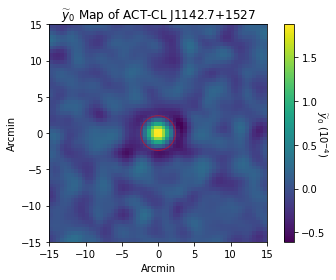

In [89]:
stamp = s18dStamp(ra, dec, s18d, name.replace(' ','_'), width = width, write = True)
print(ra, dec)
fig, axes = plt.subplots()
bound = width*60/2
plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])

draw_circle = plt.Circle((0, 0), 2.4, color = 'r',fill=False, alpha = 0.5)
axes.set_aspect(1)
axes.add_artist(draw_circle)
cbar = plt.colorbar()
cbar.set_label(r'$\widetilde{y}_0$ ($10^{-4}$)', rotation=270)

plt.xlabel('Arcmin')
plt.ylabel('Arcmin')


plt.title(r'$\widetilde{y}_0$ Map of '+str(name))
plt.savefig('./plots/for_charles/{}_y0.pdf'.format(name.replace(' ','_')))

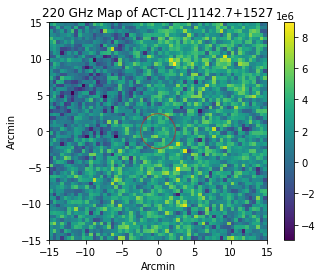

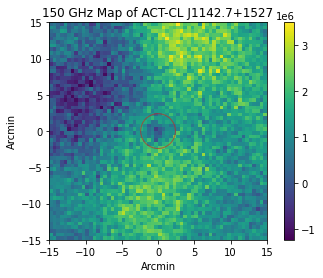

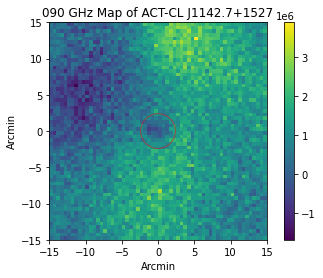

In [90]:
freqs = ['220', '150', '090']

path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'

for freq in freqs:
    cur_map = enmap.read_map(path + 'act_planck_s08_s18_cmb_f{}_night_map.fits'.format(freq))
    stamp = freqStamp(ra, dec, cur_map, name.replace(' ','_'), width = width, write = True, freq = freq)

    fig, axes = plt.subplots()
    bound = width*60/2
    plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])

    draw_circle = plt.Circle((0, 0), 2.4, color = 'r',fill=False, alpha = 0.5)
    axes.set_aspect(1)
    axes.add_artist(draw_circle)
    cbar = plt.colorbar()
    #cbar.set_label(r'($10^{-4}$)', rotation=270)

    plt.xlabel('Arcmin')
    plt.ylabel('Arcmin')


    plt.title('{} GHz Map of '.format(freq)+str(name))
    plt.savefig('./plots/for_charles/{}_{}.pdf'.format(name.replace(' ','_'), freq))
    plt.show()
    plt.close()

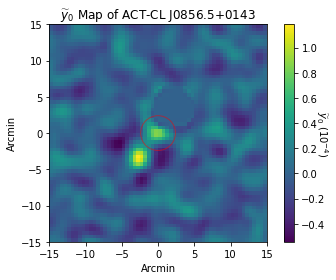

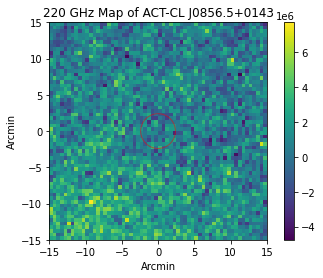

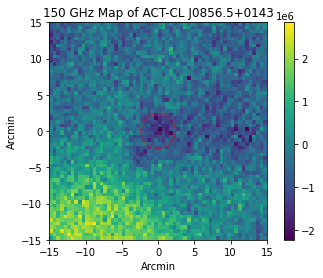

In [ ]:
stamper(name = 'ACT-CL J0856.5+0143')

In [12]:
hfi_clusters = fits.open('HFI_PCCS_SZ-union_R2.08_sourcery_missed_in_S18d_202006_optimalCatalog.fits')
hfiNames = hfi_clusters[1].data['name']
hfiRa = hfi_clusters[1].data['RADeg ']
hfiDec = hfi_clusters[1].data['decDeg']

for i, name in enumerate(hfiNames):
    if path.exists('./for_tony/mustang2/090_{}.fits'.format(name.replace(' ', '_'))): continue
    hfiStamper(name, hfiRa[i], hfiDec[i])

In [87]:
print(names[2395])

ACT-CL J1142.7+1527


In [92]:
path = '/home/r/rbond/sigurdkn/project/actpol/map_coadd/20200228/release2/'
hi_data = fits.open(path + 'act_planck_s08_s18_cmb_f150_night_map.fits')
w = wcs.WCS(hi_data[0].header)

In [98]:
hi_data[0].data.shape

(3, 10320, 43200)

In [100]:
stamp = freqStamp(ra, dec, cur_map, name.replace(' ','_'), width = width, write = False, freq = freq)


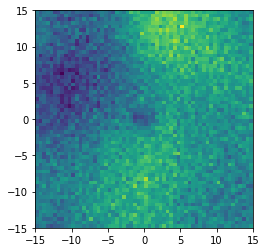

In [105]:
plt.imshow(stamp[0]*1e4, extent = [-bound,bound, -bound,bound])